# RSI指標+簡單移動平均線策略


本次策略使用兩個因子：

1. RSI指標，(英文全名：Relative Strength Index)，中文稱為「相對強弱指標」，是一種以股價漲跌為基礎，在一段時間內的收盤價，用於評估價格變動的速度（快慢) 與變化 (幅度) 的技術分析工具，RSI藉由計算一段期間內股價的漲跌變化，判斷最近的趨勢屬於偏強 (偏多) 還是偏弱 (偏空)。

2. 簡單移動平均線（SMA），(英文全名：Simple Moving Average)，是指一段特定的時間內，對價格進行簡單平均計算統計出來的數值連線，一般是用股票收盤價來計算。簡單移動平均線是觀察價格波動的一個最基礎指標之一。

In [1]:
import os
# os.environ['TEJAPI_KEY'] = "your key" 
# os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
os.environ['TEJAPI_KEY'] = "VQZyPSb1cxDuftfxpq4ZJcs0KZenR1"
os.environ['TEJAPI_BASE'] = "http://10.10.10.66"

In [2]:
# 引入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar
from zipline.sources.TEJ_Api_Data import get_Benchmark_Return

In [3]:
from zipline.sources.TEJ_Api_Data import get_universe
start = '2021-01-01'
end = '2023-12-31'
pool = get_universe(start, end, mkt = 'TWSE', stktp_c = '普通股', main_ind_c = 'M1700 化學生技醫療')
print(f'共有 {len(pool)} 檔股票：\n', pool)

共有 66 檔股票：
 ['1598', '1701', '1707', '1708', '1709', '1710', '1711', '1712', '1713', '1714', '1717', '1718', '1720', '1721', '1722', '1723', '1724', '1725', '1726', '1727', '1730', '1731', '1732', '1733', '1734', '1735', '1736', '1752', '1760', '1762', '1773', '1776', '1783', '1786', '1789', '1795', '3164', '3705', '3708', '4104', '4106', '4108', '4119', '4133', '4142', '4155', '4164', '4720', '4722', '4725', '4736', '4737', '4739', '4746', '4755', '4764', '4766', '4770', '6472', '6491', '6534', '6645', '6657', '6782', '6796', '6861']


In [5]:
start_dt, end_dt = pd.Timestamp(start, tz='utc'), pd.Timestamp(end, tz='utc')

tickers = ' '.join(pool)

os.environ['ticker'] = tickers+' IX0019'
os.environ['mdate'] = start+' '+end

tickers

'1598 1701 1707 1708 1709 1710 1711 1712 1713 1714 1717 1718 1720 1721 1722 1723 1724 1725 1726 1727 1730 1731 1732 1733 1734 1735 1736 1752 1760 1762 1773 1776 1783 1786 1789 1795 3164 3705 3708 4104 4106 4108 4119 4133 4142 4155 4164 4720 4722 4725 4736 4737 4739 4746 4755 4764 4766 4770 6472 6491 6534 6645 6657 6782 6796 6861'

In [6]:
!zipline ingest -b tquant

[2024-01-24 02:57:23.991952] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]    


In [36]:
bundle = bundles.load('tquant')
benchmark_asset = bundle.asset_finder.lookup_symbol('IX0019',as_of_date = None)
# 取所有sid
sids = bundle.asset_finder.equities_sids
# 取所有assets
assets = bundle.asset_finder.retrieve_all(sids)
# 取所有symbol
symbol = [i.symbol for i in assets]
# 用sid取assets
_asset = bundle.asset_finder.retrieve_equities([0,1])

In [23]:
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import TWEquityPricing
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.factors import SimpleMovingAverage, RSI
from zipline.pipeline.mixins import SingleInputMixin
from numexpr import evaluate
from zipline.utils.math_utils import nanmean
from zipline.pipeline.filters import StaticSids
from numexpr import evaluate
from zipline.utils.input_validation import expect_bounded
from zipline.utils.numpy_utils import rolling_window
from numpy import (
    abs,
    average,
    clip,
    diff,
    inf,
)

# 客製化因子：取得前一個日期和後一個 RSI 的差值，以此取得斜率
class RSI_diff(CustomFactor):

    inputs = (TWEquityPricing.close,)
    # We don't use the default form of `params` here because we want to
    # dynamically calculate `window_length` from the period lengths in our
    # __new__.
    params = ("rsi_period", "lag_period")

    @expect_bounded(
        rsi_period=(1, None),  # These must all be >= 1.
        lag_period=(1, None),
    )
    def __new__(cls, rsi_period=14, lag_period=2, *args, **kwargs):

        return super(RSI_diff, cls).__new__(
            cls,
            rsi_period=rsi_period,
            lag_period=lag_period,
            window_length=rsi_period + lag_period + 1,
            *args,
            **kwargs,
        )

    def compute(
        self, today, assets, out, close, rsi_period, lag_period
    ):
        def rsi(closes):
            diffs = diff(closes, axis=0)
            ups = nanmean(clip(diffs, 0, inf), axis=0)
            downs = abs(nanmean(clip(diffs, -inf, 0), axis=0))
            
            return evaluate(
                "100 - (100 / (1 + (ups / downs)))",
                local_dict={"ups": ups, "downs": downs},
                global_dict={},
                out=out,
            )
        
        new = np.array(rsi(close[-rsi_period:]))
        old = np.array(rsi(close[:-lag_period]))
        
        out[:] = new-old

# 客製化因子：取得前一個日期的均線和後一個均線的差值，以此取得斜率
class SMA_diff(CustomFactor):
    
    def compute(self, today, assets, out, data):

        out[:] = ((np.nanmean(data[1:self.window_length], axis=0) -\
                   np.nanmean(data[0:int(self.window_length)-1], axis=0))).round(4)

In [24]:
def make_pipeline(rsi_window_length, rsi_slope_wl, sma_window_length):
    
    rsi = RSI(inputs = [TWEquityPricing.close], window_length = rsi_window_length)
    rsi_slope = RSI_diff(rsi_period=rsi_window_length, lag_period=rsi_slope_wl)
    curr_price = TWEquityPricing.close.latest
    sma = SimpleMovingAverage(inputs = [TWEquityPricing.close], window_length = sma_window_length)
    sma_slope = SMA_diff(inputs=[TWEquityPricing.close], window_length = sma_window_length + 1)
    
    return Pipeline(
        columns = {
            "RSI": rsi,
            'RSI_based_MA': rsi_slope,
            "SMA": sma,
            'SMA_slope': sma_slope,
            'curr_price': curr_price
        },
        screen = ~StaticAssets([benchmark_asset])
    )
    
my_pipeline = run_pipeline(make_pipeline(14, 5, 30), start_dt, end_dt)

my_pipeline.head(822).tail(30)

RSI  RSI_based_MA  \
2021-01-22 00:00:00+00:00 Equity(29 [1762])  27.972028     12.479070   
                          Equity(30 [1773])  24.137931     -9.195402   
                          Equity(31 [1776])  40.909091      7.575758   
                          Equity(32 [1783])  40.909091    -14.904863   
                          Equity(33 [1786])   5.208333     -7.612179   
                          Equity(34 [1789])   7.843137     -2.501690   
                          Equity(35 [1795])  13.138686     -3.527981   
                          Equity(36 [3164])  20.512821    -18.376068   
                          Equity(37 [3705])  15.094340    -10.712112   
                          Equity(38 [3708])  28.440367      0.082158   
                          Equity(39 [4104])  28.571429    -15.873016   
                          Equity(40 [4106])  32.710280      0.964249   
                          Equity(41 [4108])  48.022087    -18.305747   
                          Equity(42 [4119])  66.149871    -31.487924   
                          Equity(43 [4133])  44.843049      9.903290   
                          Equity(44 [4142])  42.500000      9.490291   
                          Equity(45 [4155])  16.279070    -12.887597   
                          Equity(46 [4164])   9.375000      5.803571   
                          Equity(47 [4720])  42.028986      5.665349   
                          Equity(48 [4722])  52.991453     -6.099456   
                          Equity(50 [4736])  33.333333    -17.829457   
                          Equity(51 [4737])  31.707317     10.085695   
                          Equity(52 [4739])  25.714286    -16.146179   
                          Equity(53 [4746])  17.592593     -2.407407   
                          Equity(54 [4755])  25.000000      2.419355   
                          Equity(55 [4764])  44.186047      5.055612   
                          Equity(56 [4766])  24.137931    -13.362069   
                          Equity(58 [6472])  26.250000      5.250000   
                          Equity(59 [6491])  15.671642     -5.380990   
2021-01-25 00:00:00+00:00 Equity(0 [1598])   40.476190     -2.600733   

                                                    SMA  SMA_slope  curr_price  
2021-01-22 00:00:00+00:00 Equity(29 [1762])   57.478571    -0.2137       54.70  
                          Equity(30 [1773])  105.821429    -0.3324      101.50  
                          Equity(31 [1776])   16.650000    -0.0154       16.45  
                          Equity(32 [1783])   22.864286    -0.0396       22.35  
                          Equity(33 [1786])   58.064286    -0.4203       52.60  
                          Equity(34 [1789])   26.839286    -0.1761       24.55  
                          Equity(35 [1795])   76.678571    -0.5291       69.80  
                          Equity(36 [3164])   21.767857    -0.0591       21.00  
                          Equity(37 [3705])   43.864286    -0.0780       42.85  
                          Equity(38 [3708])  144.357143    -0.9505      132.00  
                          Equity(39 [4104])   55.707143    -0.0621       54.90  
                          Equity(40 [4106])   27.514286    -0.0665       26.65  
                          Equity(41 [4108])   26.048571    -0.1691       23.85  
                          Equity(42 [4119])   92.428571     0.2209       95.30  
                          Equity(43 [4133])   53.400000     0.0385       53.90  
                          Equity(44 [4142])   51.300000    -0.0154       51.10  
                          Equity(45 [4155])   26.375000    -0.0673       25.50  
                          Equity(46 [4164])   37.803571    -0.1464       35.90  
                          Equity(47 [4720])   15.903571    -0.0195       15.65  
                          Equity(48 [4722])   30.596429     0.0118       30.75  
                          Equity(50 [4736])  180.428571    -0.8791      169.00  
                          Equity(51 

當 RSI 小於 30 且 RSI 斜率為正、股價均線下行時，表示買方逐漸轉強、股價來到低點，此時買入1000股。

當 RSI 介於 45 到 55 之間且 RSI 斜率為正、股價均線上揚時，表示行情持續看多、預期股價持續上漲，此時加碼買入 1000 股。

當 RSI 大於 70 且 RSI 斜率為負、股價均線上揚時，表示賣方逐漸轉強、股價來到高點，此時拋售所有股票。

In [29]:
from zipline.finance import slippage, commission
from zipline.api import set_slippage, set_commission, set_benchmark, attach_pipeline, order, order_target, symbol, pipeline_output, record

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost = 0.001425 + 0.003 / 2))
    attach_pipeline(make_pipeline(14, 10, 10), 'mystrats')
    set_benchmark(symbol('IX0019'))

## 策略買賣規則

1. 當 RSI 小於 30 且 RSI 斜率為正、股價均線下行時，表示買方逐漸轉強、股價來到低點，此時買入1000股。

2. 當 RSI 介於 45 到 55 之間且 RSI 斜率為正、股價均線上揚時，表示行情持續看多、預期股價持續上漲，此時加碼買入 1000 股。

3. 當 RSI 大於 70 且 RSI 斜率為負、股價均線上揚時，表示賣方逐漸轉強、股價來到高點，此時拋售所有股票。

In [30]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrats')
    for i in out_dir.index:
        sym = i.symbol
        rsi = out_dir.loc[i, "RSI"]
        rsi_based_ma = out_dir.loc[i, 'RSI_based_MA']
        sma = out_dir.loc[i, "SMA"]
        sma_slope = out_dir.loc[i, 'SMA_slope']
        curr_price = out_dir.loc[i, 'curr_price']
        
        cash_position = context.portfolio.cash    # 記錄現金水位
        stock_position = context.portfolio.positions[i].amount    # 記錄股票部位

        buy, sell = False, False
        
        record(
           **{
                f'price_{sym}':curr_price,
                f'RSI_{sym}':rsi,
                f'RSI_based_MA_{sym}':rsi_based_ma,
                f'SMA_{sym}':sma,
                f'SMA_slope_{sym}': sma_slope,
                f'buy_{buy}':buy,
                f'sell_{sym}':sell
            }
        )
        
        if stock_position == 0:
            if (rsi <= 30) and (rsi_based_ma > 0) and (sma_slope < 0) and (cash_position >= curr_price * 1000):
                order(i, 1000)
                buy = True
                record(
                    **{
                        f'buy_{sym}':buy
                    }
                )
            else:
                pass
        elif stock_position > 0:
            if (rsi > 45) and (rsi < 55) and (rsi_based_ma > 0) and (sma_slope > 0) and (cash_position >= curr_price * 1000):
                order(i, 1000)
                buy = True
                record(
                    **{
                        f'buy_{sym}':buy
                    }
                )
            elif (rsi >= 70) and (rsi_based_ma < 0) and (sma_slope > 0) and (stock_position > 0):
                order_target(i, 0)
                sell = True
                record(
                    **{
                        f'sell_{sym}':sell
                    }
                )
            else:
                pass
        else:
            pass

In [31]:
def analyze(context, perf):
    pass

In [32]:
from zipline import run_algorithm
results = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=5e6,
    handle_data = handle_data
)

# results

In [33]:
# 回測結果
results

,period_open,period_close,returns,portfolio_value,longs_count,shorts_count,starting_cash,long_value,short_value,long_exposure,...,RSI_based_MA_6534,SMA_6534,SMA_slope_6534,sell_6534,price_6645,RSI_6645,RSI_based_MA_6645,SMA_6645,SMA_slope_6645,sell_6645
2021-01-04 13:30:00+08:00,2021-01-04 09:01:00+08:00,2021-01-04 13:30:00+08:00,0.000000,5.000000e+06,0,0,5.000000e+06,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 13:30:00+08:00,2021-01-05 09:01:00+08:00,2021-01-05 13:30:00+08:00,0.000000,5.000000e+06,0,0,5.000000e+06,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06 13:30:00+08:00,2021-01-06 09:01:00+08:00,2021-01-06 13:30:00+08:00,0.000000,5.000000e+06,0,0,5.000000e+06,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07 13:30:00+08:00,2021-01-07 09:01:00+08:00,2021-01-07 13:30:00+08:00,0.000000,5.000000e+06,0,0,5.000000e+06,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-08 13:30:00+08:00,2021-01-08 09:01:00+08:00,2021-01-08 13:30:00+08:00,0.000000,5.000000e+06,0,0,5.000000e+06,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,0.000929,6.812010e+06,22,6,1.932263e+05,9199175.75,-2633497.50,9199175.75,...,NaN,83.200000,0.8000,False,36.40,0.000000,NaN,37.125000,-0.7250,False
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,0.005489,6.849403e+06,22,6,2.463313e+05,9188882.60,-2648280.00,9188882.60,...,NaN,82.966667,-0.2333,False,35.90,0.000000,NaN,36.716667,-0.4083,False
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,0.017415,6.968685e+06,22,6,3.088000e+05,9391104.85,-2649102.50,9391104.85,...,NaN,82.475000,-0.4917,False,35.50,0.000000,NaN,36.412500,-0.3042,False
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,-0.000753,6.963435e+06,21,7,2.266829e+05,9329816.00,-2675936.25,9329816.00,...,NaN,81.900000,-0.5750,False,34.20,0.000000,NaN,35.970000,-0.4425,False


<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei


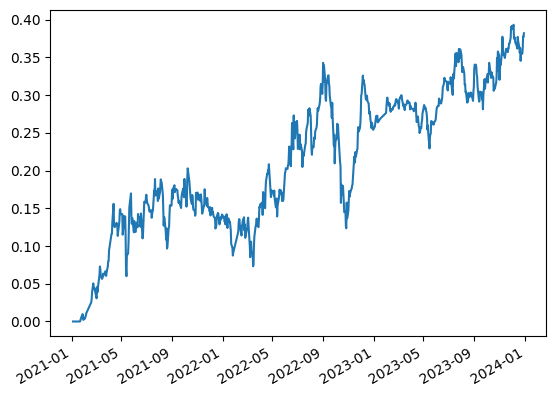

In [34]:
# 報酬率變化
results.returns.cumsum().plot()

Start date,2021-01-04
End date,2023-12-29
Total months,34
,Backtest
Annual return,12.321%
Cumulative returns,39.951%
Annual volatility,17.815%
Sharpe ratio,0.74
Calmar ratio,0.61
Stability,0.77
Max drawdown,-20.247%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.25,2022-08-31,2022-10-26,2023-07-25,216
1,12.56,2021-10-08,2022-03-15,2022-06-09,161
2,9.38,2021-04-12,2021-05-13,2021-05-24,30
3,8.98,2021-07-21,2021-08-19,2021-10-08,56
4,7.85,2023-07-25,2023-09-21,2023-11-07,72


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.05%,-4.93%,4.50%


Top 10 long positions of all time,max
sid,
6491,30.39%
6472,28.13%
3708,22.37%
4755,18.95%
1736,17.67%
1707,14.71%
6796,12.97%
1795,10.31%
4737,9.98%


Top 10 short positions of all time,max
sid,
1735,-20.61%
1752,-10.97%
1730,-7.44%
1762,-7.22%
1725,-2.23%
3705,-1.96%
4722,-1.47%


Top 10 positions of all time,max
sid,
6491,30.39%
6472,28.13%
3708,22.37%
1735,20.61%
4755,18.95%
1736,17.67%
1707,14.71%
6796,12.97%
1752,10.97%


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei


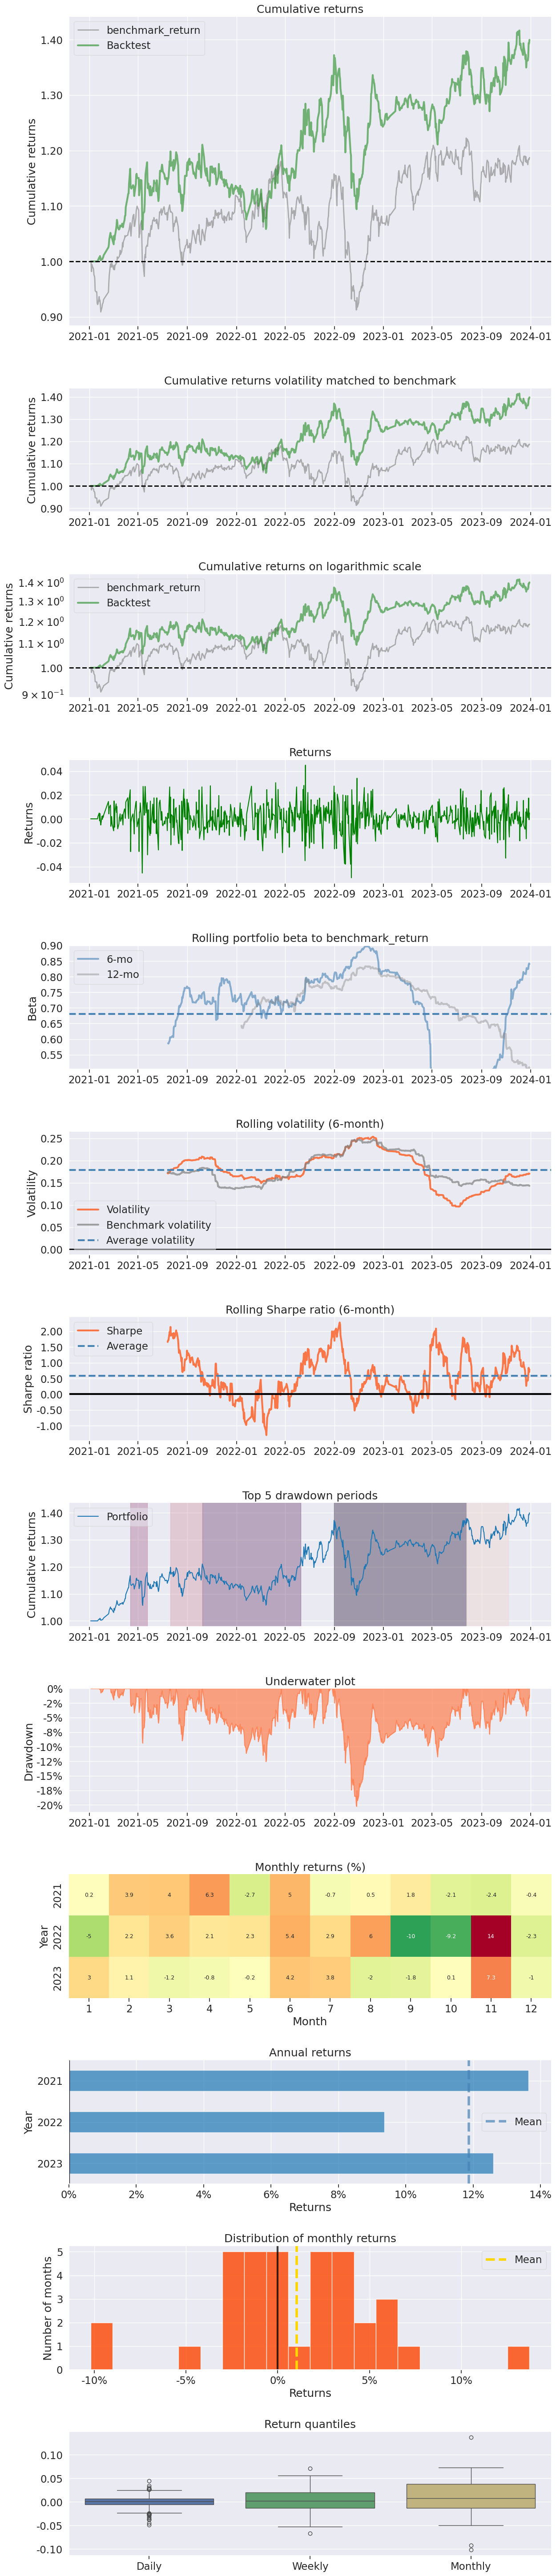

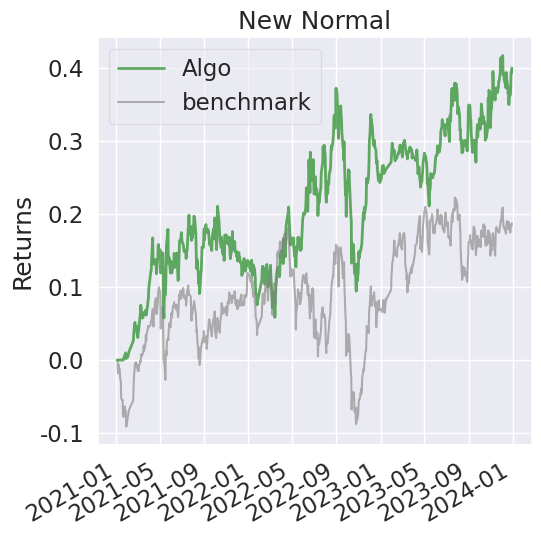

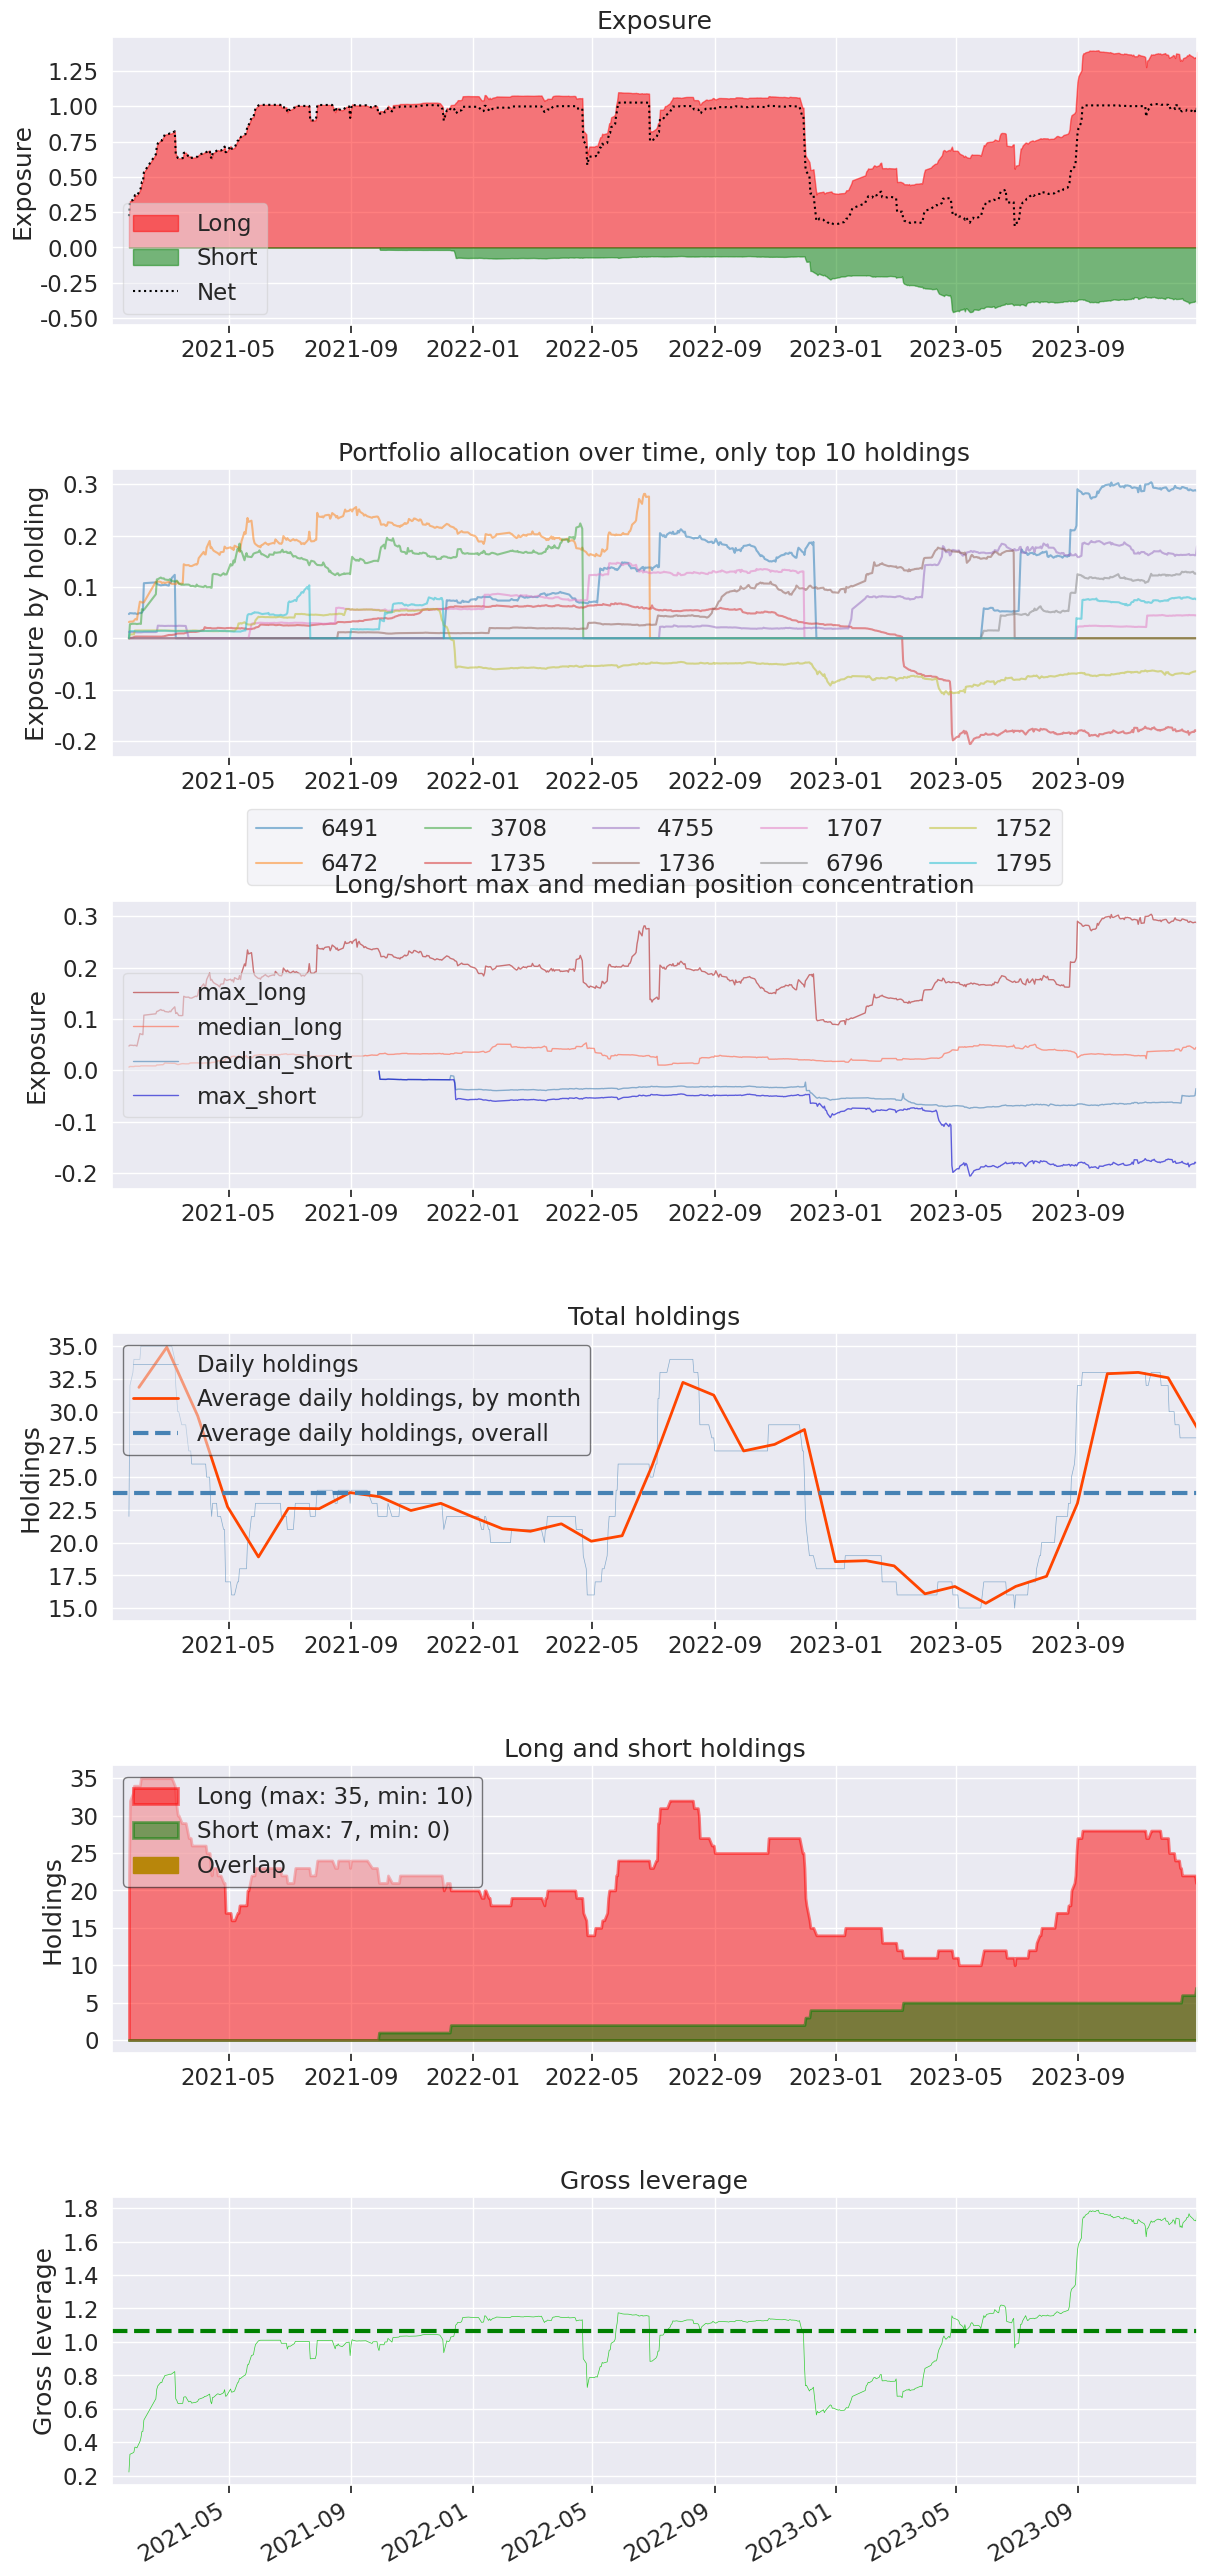

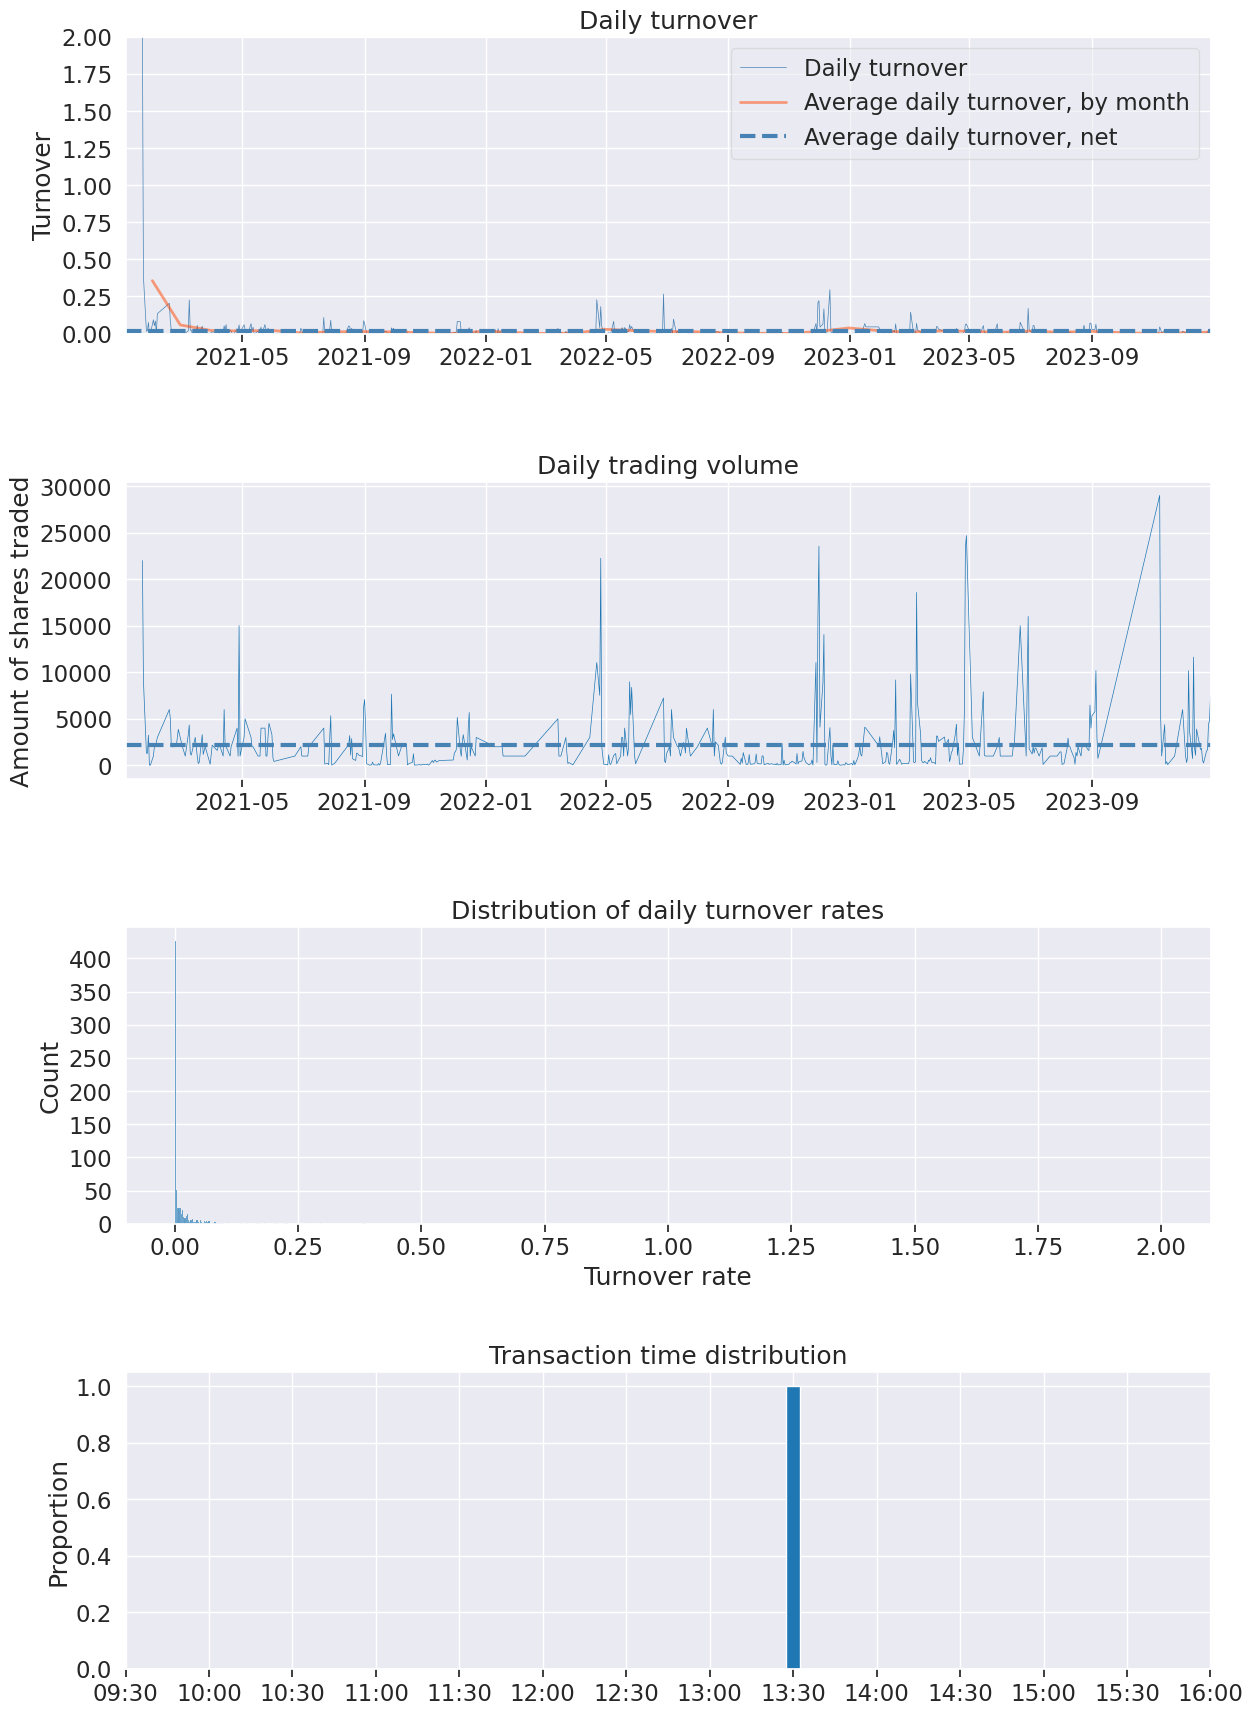

In [35]:
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions,
                          benchmark_rets = benchmark_rets,
                          round_trips=False)